### Comparation of 3 base models


In [223]:
# usual imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
# data methods
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# misc
import joblib

In [262]:
# create a class that we can pass to the pipeline
class DataCleaner:

    def __init__(self):
        print('Cleaning ...')

    def clean_numeric(self, df):
        #
        # Construction year
        df['construction_year'] = df['construction_year'].replace(0, np.nan)
        #Impute using region + installer
        df['construction_year'] = df.groupby(['region', 'installer'])['construction_year'].transform(
            lambda x: x.fillna(x.median())
        )
        #Impute using region only (for rows still missing)
        df['construction_year'] = df.groupby('region')['construction_year'].transform(
            lambda x: x.fillna(x.median())
        )
        #Use recorded year - 13
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['recorded_year'] = df['date_recorded'].dt.year
        df['construction_year'] = df['construction_year'].fillna(df['recorded_year'] - 13)
        #
        # gps_height
        df['gps_height'] = df['gps_height'].apply(lambda x: np.nan if x <= 0 else x)
        # Fill using median per lga
        df['gps_height'] = df.groupby(['lga'])['gps_height'].transform(
            lambda x: x.fillna(x.median())
        )
        # Fill any still missing using region median
        df['gps_height'] = df.groupby(['region'])['gps_height'].transform(
            lambda x: x.fillna(x.median())
        ) 
#        df['gps_height'] = df['gps_height'].fillna(df['gps_height'].median())
        #location
        df['longitude'] = df['longitude'].replace(0, np.nan)
        df['latitude'] = df['latitude'].where(df['latitude'] < -0.5, np.nan) # too close to the equator
        for i in ['latitude','longitude']:
            df[i] = df.groupby(['lga'])[i].transform(lambda x: x.fillna(x.median))
            df[i] = df.groupby(['region'])[i].transform(lambda x: x.fillna(x.median))
        df.longitude = pd.to_numeric(df.longitude, errors='coerce')
        df.latitude = pd.to_numeric(df.latitude, errors='coerce')
        #
        # population
        # Fill population using median by district_code
        df['population'] = df.groupby('lga')['population'].transform(
            lambda x: x.fillna(x.median())
        )
        # Fill any still missing with median by region, then overall median
        df['population'] = df.groupby('region')['population'].transform(
            lambda x: x.fillna(x.median())
        )
        df['population'] = df['population'].fillna(df.population.median)
        # Bin the outcome, see how it behaves
        df['population'] = pd.cut(df['population'], [-1,1,25,90,160,260,9999999], labels=[0,0.2,0.3,0.4,0.6,1])
        df['population'] = df['population'].astype(float)
        #
        # amount_tsh
        df['amount_tsh'] = df['amount_tsh'].apply(lambda x: min(x, 15000))
        df['amount_tsh'] = df['amount_tsh'].apply(lambda x: np.power(x,0.3))
        return df

    def clean_categorical(self, df):
            ### Encode categorical variables
        # Encode 'quantity' (and typo fix: 'insufficent' -> 'insufficient')
        df['quantity'] = df['quantity'].replace({
            'enough': 1,
            'seasonal': 0.6,
            'insufficient': 0.4,
            'dry': 0,
            'unknown': 0
        })
        df.quantity = pd.to_numeric(df.quantity, errors='coerce')

        # Encode 'water_quality' as binary: good = 1, else 0
        df['water_quality'] = np.where(df['water_quality'] == 'soft', 1, 0)
        # Encode 'waterpoint_type' (1 = preferred type, 0 = everything else)
        preferred_waterpoint = ['communal standpipe multiple', 'communal standpipe']
        df['waterpoint_type'] = df['waterpoint_type'].apply(lambda x: 1 if x in preferred_waterpoint else 0)
        # Encode 'permit' as binary: True = 1, False, missing = 0
        df['permit'] = np.where(df['permit'] == 'True', 1, 0)
        # Encode 'payment' as binary: never pay = 0, else = 1
        df['payment'] = np.where(df['payment'] == 'never pay', 0, 1)
        # Encode 'source' (1 = preferred sources, 0 = everything else)
        preferred_sources = ['spring', 'river', 'rainwater harvesting']
        df['source'] = df['source'].apply(lambda x: 1 if x in preferred_sources else 0)
        # Encode 'payment' as binary: never pay = 0, else = 1
        df['extraction_type_class'] = np.where(df['extraction_type_class'] == 'gravity', 0, 1)
        # Encode 'scheme_management' (1 = VWC, others 0)
        df['scheme_management'] = np.where(df['scheme_management'] == 'VWC', 0, 1)
        # one hot encoder for basin 
        df = pd.get_dummies(data=df, columns=['basin'], drop_first=True, dtype=int)
        return df

    def selection(self, df):
         #  Drop other columns and only keep these:
        # df_small = df[['amount_tsh',
        #     'gps_height',
        #     'population',
        #     'construction_year',
        #     'extraction_type_class',
        #     'payment',
        #     'water_quality',
        #     'quantity',
        #     'source',
        #     'waterpoint_type'
        #    ]]
        #  #  Drop other columns and only keep these:
        # df_medium = df[['amount_tsh',
        #          'gps_height',
        #          'longitude',
        #          'latitude',
        #          'population',
        #          'construction_year',
        #          'extraction_type_class',
        #          'payment',
        #         'water_quality',
        #         'quantity',
        #         'source',
        #         'waterpoint_type',, 'basin_Lake Nyasa', 'basin_Lake Rukwa',
        #         'basin_Lake Tanganyika', 'basin_Lake Victoria', 'basin_Pangani',
        #         'basin_Rufiji', 'basin_Ruvuma / Southern Coast', 'basin_Wami / Ruvu'
        #         'scheme_management'
        #        ]]
        df = df[['amount_tsh',
                 'gps_height',
                 'longitude',
                 'latitude',
                 'population',
                 'construction_year',
                 'extraction_type_class',
                 'payment',
                'water_quality',
                'quantity',
                'source',
                'waterpoint_type', 
                'scheme_management', 'basin_Lake Nyasa', 'basin_Lake Rukwa',
                'basin_Lake Tanganyika', 'basin_Lake Victoria', 'basin_Pangani',
                'basin_Rufiji', 'basin_Ruvuma / Southern Coast', 'basin_Wami / Ruvu'
               ]]
        df['tshXpayment'] = df.amount_tsh * df.payment
        df['extractXsource'] = df.extraction_type_class * df.source
        df['popXtsh'] = df.population * df.amount_tsh
        df['popXquant'] = df.population * df.quantity
        df['popXsource'] = df.population * df.source
        df['extractXheight'] = df.extraction_type_class * df.gps_height
        df['typeXsource'] = df.waterpoint_type * df.source
        df['typeXyear'] = df.waterpoint_type * df.construction_year
        df['yearXpop'] = df.construction_year * df.population
        df['quantXsource'] = df.quantity * df.source
        df['yearsq'] = np.sqrt(df.construction_year + 1)
        df_large = df

        return df#_small, df_medium, df_large

    def clean_data(self, df): 
        df = self.clean_numeric(df) 
        df = self.clean_categorical(df)
        df = self.selection(df)
        return df
        
print('cool')

cool


In [263]:
# Testing the cleaning function on the original training data
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_path = os.path.join(parent_dir, 'data')
out_path = os.path.join(parent_dir, 'outputs')

# Read the files
train = pd.read_csv(os.path.join(data_path, 'train.csv'))
labels = pd.read_csv(os.path.join(data_path, 'train_labels.csv')) 

# Try the function
cleaner = DataCleaner()
X = cleaner.clean_data(train)

X.isna().sum() # returns all floats and integers, which makes me happier than it should


Cleaning ...


amount_tsh                           0
gps_height                       12115
longitude                         1812
latitude                          1812
population                           0
construction_year                    0
extraction_type_class                0
payment                              0
water_quality                        0
quantity                             0
source                               0
waterpoint_type                      0
scheme_management                    0
basin_Lake Nyasa                     0
basin_Lake Rukwa                     0
basin_Lake Tanganyika                0
basin_Lake Victoria                  0
basin_Pangani                        0
basin_Rufiji                         0
basin_Ruvuma / Southern Coast        0
basin_Wami / Ruvu                    0
tshXpayment                          0
extractXsource                       0
popXtsh                              0
popXquant                            0
popXsource               

In [251]:
X['gps_height'] = X.gps_height.transform(lambda x: x.fillna(x.median()))

X.gps_height.isna().sum()

np.int64(0)

In [257]:
# create a class that we can pass to the pipeline
def clean_func(df):
    #
    # Construction year
    df['construction_year'] = df['construction_year'].replace(0, np.nan)
    #Impute using region + installer
    df['construction_year'] = df.groupby(['region', 'installer'])['construction_year'].transform(
        lambda x: x.fillna(x.median())
    )
    #Impute using region only (for rows still missing)
    df['construction_year'] = df.groupby('region')['construction_year'].transform(
        lambda x: x.fillna(x.median())
    )
    #Use recorded year - 13
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['recorded_year'] = df['date_recorded'].dt.year
    df['construction_year'] = df['construction_year'].fillna(df['recorded_year'] - 13)
    #
    # gps_height
    df['gps_height'] = df['gps_height'].apply(lambda x: np.nan if x <= 0 else x)
    # Fill using median per lga
    df['gps_height'] = df.groupby('lga')['gps_height'].transform(
        lambda x: x.fillna(x.median())
    )
    # Fill any still missing using region median
    df['gps_height'] = df.groupby('region')['gps_height'].transform(
        lambda x: x.fillna(x.median())
    )
    #
    #location
    df['longitude'] = df['longitude'].replace(0, np.nan)
    df['latitude'] = df['latitude'].where(df['latitude'] < -0.5, np.nan) # too close to the equator
    for i in ['latitude','longitude']:
        df[i] = df.groupby('lga')[i].transform(lambda x: x.fillna(x.median))
        df[i] = df.groupby('region')[i].transform(lambda x: x.fillna(x.median))
    df.longitude = pd.to_numeric(df.longitude, errors='coerce')
    df.latitude = pd.to_numeric(df.latitude, errors='coerce')
    #
    # population
    # Fill population using median by district_code
    df['population'] = df.groupby('lga')['population'].transform(
        lambda x: x.fillna(x.median())
    )
    # Fill any still missing with median by region, then overall median
    df['population'] = df.groupby('region')['population'].transform(
        lambda x: x.fillna(x.median())
    )
    df['population'] = df['population'].fillna(df.population.median)
    # Bin the outcome, see how it behaves
    df['population'] = pd.cut(df['population'], [-1,1,25,90,160,260,9999999], labels=[0,0.2,0.3,0.4,0.6,1])
    df['population'] = df['population'].astype(float)
    #
    # amount_tsh
    df['amount_tsh'] = df['amount_tsh'].apply(lambda x: min(x, 15000))
    df['amount_tsh'] = df['amount_tsh'].apply(lambda x: np.power(x,0.3))
        ### Encode categorical variables
    # Encode 'quantity' (and typo fix: 'insufficent' -> 'insufficient')
    df['quantity'] = df['quantity'].replace({
        'enough': 1,
        'seasonal': 0.6,
        'insufficient': 0.4,
        'dry': 0,
        'unknown': 0
    })
    df.quantity = pd.to_numeric(df.quantity, errors='coerce')

    # Encode 'water_quality' as binary: good = 1, else 0
    df['water_quality'] = np.where(df['water_quality'] == 'soft', 1, 0)
    # Encode 'waterpoint_type' (1 = preferred type, 0 = everything else)
    preferred_waterpoint = ['communal standpipe multiple', 'communal standpipe']
    df['waterpoint_type'] = df['waterpoint_type'].apply(lambda x: 1 if x in preferred_waterpoint else 0)
    # Encode 'permit' as binary: True = 1, False, missing = 0
    df['permit'] = np.where(df['permit'] == 'True', 1, 0)
    # Encode 'payment' as binary: never pay = 0, else = 1
    df['payment'] = np.where(df['payment'] == 'never pay', 0, 1)
    # Encode 'source' (1 = preferred sources, 0 = everything else)
    preferred_sources = ['spring', 'river', 'rainwater harvesting']
    df['source'] = df['source'].apply(lambda x: 1 if x in preferred_sources else 0)
    # Encode 'payment' as binary: never pay = 0, else = 1
    df['extraction_type_class'] = np.where(df['extraction_type_class'] == 'gravity', 0, 1)
    # Encode 'scheme_management' (1 = VWC, others 0)
    df['scheme_management'] = np.where(df['scheme_management'] == 'VWC', 0, 1)
    # one hot encoder for basin 
    df = pd.get_dummies(data=df, columns=['basin'], drop_first=True, dtype=int)
    ### Select what's good
     #  Drop other columns and only keep these:
    # df_small = df[['amount_tsh',
    #     'gps_height',
    #     'population',
    #     'construction_year',
    #     'extraction_type_class',
    #     'payment',
    #     'water_quality',
    #     'quantity',
    #     'source',
    #     'waterpoint_type'
    #    ]]
    #  #  Drop other columns and only keep these:
    # df_medium = df[['amount_tsh',
    #          'gps_height',
    #          'longitude',
    #          'latitude',
    #          'population',
    #          'construction_year',
    #          'extraction_type_class',
    #          'payment',
    #         'water_quality',
    #         'quantity',
    #         'source',
    #         'waterpoint_type',, 'basin_Lake Nyasa', 'basin_Lake Rukwa',
    #         'basin_Lake Tanganyika', 'basin_Lake Victoria', 'basin_Pangani',
    #         'basin_Rufiji', 'basin_Ruvuma / Southern Coast', 'basin_Wami / Ruvu'
    #         'scheme_management'
    #        ]]
    df = df[['amount_tsh',
             'gps_height',
             'longitude',
             'latitude',
             'population',
             'construction_year',
             'extraction_type_class',
             'payment',
            'water_quality',
            'quantity',
            'source',
            'waterpoint_type', 
            'scheme_management', 'basin_Lake Nyasa', 'basin_Lake Rukwa',
            'basin_Lake Tanganyika', 'basin_Lake Victoria', 'basin_Pangani',
            'basin_Rufiji', 'basin_Ruvuma / Southern Coast', 'basin_Wami / Ruvu'
           ]]
    df['tshXpayment'] = df.amount_tsh * df.payment
    df['extractXsource'] = df.extraction_type_class * df.source
    df['popXtsh'] = df.population * df.amount_tsh
    df['popXquant'] = df.population * df.quantity
    df['popXsource'] = df.population * df.source
    df['extractXheight'] = df.extraction_type_class * df.gps_height
    df['typeXsource'] = df.waterpoint_type * df.source
    df['typeXyear'] = df.waterpoint_type * df.construction_year
    df['yearXpop'] = df.construction_year * df.population
    df['quantXsource'] = df.quantity * df.source
    df['yearsq'] = np.sqrt(df.construction_year + 1)
    df_large = df
    print(df.isna().sum())
    return df#_small, df_medium, df_large

#def clean_data(self, df): 
#    df = self.clean_numeric(df) 
#    df = self.clean_categorical(df)
#    df = self.selection(df)
#    return df

print('cool')

my_transformer = FunctionTransformer(clean_func)

cool


id                           0
amount_tsh                   0
date_recorded                0
funder                    3637
gps_height               12115
installer                 3655
longitude                 1812
latitude                  1812
wpt_name                     2
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management            0
scheme_name              28810
permit                       0
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [246]:
from sklearn.preprocessing import FunctionTransformer

# data_transformer = FunctionTransformer(cleaner.clean_data)
# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(labels['status_group']) 
X = train

# Define features and target 
y = y_encoded
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


pipeline = Pipeline([
    ('data_transformer', my_transformer),
    ('scaler', StandardScaler()), 
    ('logreg', LogisticRegression(max_iter=700))
])


# Parameter grid
param_grid = {
    'logreg__C': [0.01, 0.1],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['lbfgs', 'saga']
}

# Grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='accuracy')
grid_search.fit(X_train, y_train)  # this is essential

# Check best_estimator_
print(" Type:", type(grid_search))
print(" Best Estimator:", grid_search.best_estimator_)


amount_tsh                          0
gps_height                       4767
longitude                         700
latitude                          700
population                          0
construction_year                   0
extraction_type_class               0
payment                             0
water_quality                       0
quantity                            0
source                              0
waterpoint_type                     0
scheme_management                   0
basin_Lake Nyasa                    0
basin_Lake Rukwa                    0
basin_Lake Tanganyika               0
basin_Lake Victoria                 0
basin_Pangani                       0
basin_Rufiji                        0
basin_Ruvuma / Southern Coast       0
basin_Wami / Ruvu                   0
tshXpayment                         0
extractXsource                      0
popXtsh                             0
popXquant                           0
popXsource                          0
extractXheig

amount_tsh                          0
gps_height                       4905
longitude                         742
latitude                          742
population                          0
construction_year                   0
extraction_type_class               0
payment                             0
water_quality                       0
quantity                            0
source                              0
waterpoint_type                     0
scheme_management                   0
basin_Lake Nyasa                    0
basin_Lake Rukwa                    0
basin_Lake Tanganyika               0
basin_Lake Victoria                 0
basin_Pangani                       0
basin_Rufiji                        0
basin_Ruvuma / Southern Coast       0
basin_Wami / Ruvu                   0
tshXpayment                         0
extractXsource                      0
popXtsh                             0
popXquant                           0
popXsource                          0
extractXheig

ValueError: 
All the 8 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jim/coding/water_pumps/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jim/coding/water_pumps/venv/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jim/coding/water_pumps/venv/lib/python3.12/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/home/jim/coding/water_pumps/venv/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jim/coding/water_pumps/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py", line 1222, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/home/jim/coding/water_pumps/venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jim/coding/water_pumps/venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/home/jim/coding/water_pumps/venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1107, in check_array
    _assert_all_finite(
  File "/home/jim/coding/water_pumps/venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/home/jim/coding/water_pumps/venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [226]:
labels.columns

Index(['id', 'status_group'], dtype='object')

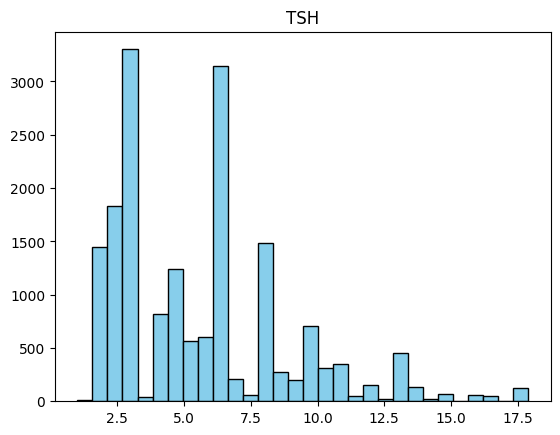

In [207]:

df = pd.read_csv(os.path.join(data_path, 'train.csv')) 

df['amount_tsh'] = df['amount_tsh'].apply(lambda x: min(x, 15000))
df['amount_tsh'] = df['amount_tsh'].apply(lambda x: np.power(x,0.3))
fig, ax1 = plt.subplots(1,1)
ax1.hist(df['amount_tsh'], bins=30, color='skyblue', edgecolor='black', range=(1, max(df['amount_tsh'])))
ax1.set_title('TSH')
plt.show()

pt.fit(data):  PowerTransformer()
pt.lambdas_:  [ 0.81761727 -0.05022969]
pt.transform(data)  [[-1.41108034 -1.38481521]
 [-0.36251621 -0.25831859]
 [ 0.49653431  0.24467264]
 [ 1.27706224  1.39846116]]
